# Collation with decision tree

## Find ngrams and positions in witnesses

In [65]:
# two witnesses, with repetition and transposition
w1 = "the red and the black cat"
w2 = "the black and the red cat"

In [66]:
def tokenize_witnesses(w1_string, w2_string):
    '''Return list of witnesses, each represented by a list of tokens'''
    w1_tokens = w1.split()
    w2_tokens = w2.split()
    witnesses = [w1_tokens, w2_tokens]
    return witnesses

In [67]:
witnesses = tokenize_witnesses(w1, w2)
print(witnesses)

[['the', 'red', 'and', 'the', 'black', 'cat'], ['the', 'black', 'and', 'the', 'red', 'cat']]


In [68]:
from collections import defaultdict 

# create a function that creates n-grams and returns the offsets
def compute_ngrams(witness, n):
   output = defaultdict(list)
   for i in range(len(witness)-n+1):
       g = ' '.join(witness[i:i+n])
       output[g].append(i)
   return output

In [69]:
for witness in witnesses:
    print(compute_ngrams(witness, 1))
    print(compute_ngrams(witness, 2))


defaultdict(<class 'list'>, {'the': [0, 3], 'red': [1], 'and': [2], 'black': [4], 'cat': [5]})
defaultdict(<class 'list'>, {'the red': [0], 'red and': [1], 'and the': [2], 'the black': [3], 'black cat': [4]})
defaultdict(<class 'list'>, {'the': [0, 3], 'black': [1], 'and': [2], 'red': [4], 'cat': [5]})
defaultdict(<class 'list'>, {'the black': [0], 'black and': [1], 'and the': [2], 'the red': [3], 'red cat': [4]})


In [70]:
# find bigrams common to the two witnesses
w1_bigrams = compute_ngrams(witnesses[0], 2)
w2_bigrams = compute_ngrams(witnesses[1], 2)
shared_keys = w1_bigrams.keys() & w2_bigrams.keys()
print(shared_keys)

{'the red', 'the black', 'and the'}


In [71]:
from collections import defaultdict

def compute_ngrams_all(witness):
   '''Create a function that creates n-grams and returns the offsets'''
   output = defaultdict(list)
   output2 = {}
   for n in range(1, len(witness) + 1):
       for i in range(len(witness)-n+1):
           g = ' '.join(witness[i:i+n])
           output[g].append(i)
           output2[g] = n
   return output, output2

In [72]:
# compute ngrams for all (both) witnesses
ngram_offset_by_witness_dict = {}
ngram_length = {}
for index, witness in enumerate(witnesses):
    map1, map2 = compute_ngrams_all(witness)
    ngram_offset_by_witness_dict['w' + str(index + 1)] = map1
    ngram_length.update(map2)

for key in ngram_offset_by_witness_dict.keys():
    print(key, ngram_offset_by_witness_dict[key])

print(ngram_length)

w1 defaultdict(<class 'list'>, {'the': [0, 3], 'red': [1], 'and': [2], 'black': [4], 'cat': [5], 'the red': [0], 'red and': [1], 'and the': [2], 'the black': [3], 'black cat': [4], 'the red and': [0], 'red and the': [1], 'and the black': [2], 'the black cat': [3], 'the red and the': [0], 'red and the black': [1], 'and the black cat': [2], 'the red and the black': [0], 'red and the black cat': [1], 'the red and the black cat': [0]})
w2 defaultdict(<class 'list'>, {'the': [0, 3], 'black': [1], 'and': [2], 'red': [4], 'cat': [5], 'the black': [0], 'black and': [1], 'and the': [2], 'the red': [3], 'red cat': [4], 'the black and': [0], 'black and the': [1], 'and the red': [2], 'the red cat': [3], 'the black and the': [0], 'black and the red': [1], 'and the red cat': [2], 'the black and the red': [0], 'black and the red cat': [1], 'the black and the red cat': [0]})
{'the': 1, 'red': 1, 'and': 1, 'black': 1, 'cat': 1, 'the red': 2, 'red and': 2, 'and the': 2, 'the black': 2, 'black cat': 2, '

In [73]:
# find keys shared by *all* witnesses
shared_ngrams = set(ngram_offset_by_witness_dict["w1"].keys())
for value in ngram_offset_by_witness_dict.values():
    shared_ngrams = shared_ngrams.intersection(value.keys())

print(shared_ngrams)

{'black', 'red', 'and the', 'cat', 'the black', 'and', 'the', 'the red'}


In [74]:
# use shared keys to find potential alignments
# NB: works for only two witnesses
# output format: {ngram : [(0,1), (2,3)]}, where 
#   the two entries in each tuple are for witnesses A and B
from collections import defaultdict

potential_alignments = defaultdict(list)
for ngram in shared_ngrams:
    for w1_offset in ngram_offset_by_witness_dict['w1'][ngram]:
        for w2_offset in ngram_offset_by_witness_dict['w2'][ngram]:
            potential_alignments[ngram].append((w1_offset, w2_offset))

print(potential_alignments)

defaultdict(<class 'list'>, {'black': [(4, 1)], 'red': [(1, 4)], 'and the': [(2, 2)], 'cat': [(5, 5)], 'the black': [(3, 0)], 'and': [(2, 2)], 'the': [(0, 0), (0, 3), (3, 0), (3, 3)], 'the red': [(0, 3)]})


## Build decision tree

In [75]:
# Find actual alignments (ngrams with positions in witnesses)
#
# Build dictionary of offset_tuple : list_of_ngrams
#
# Source: https://stackoverflow.com/questions/6190331/how-to-implement-an-ordered-default-dict
#
# agglomerate = collections.OrderedDict()
# for i, x in some_generator():
#     agglomerate.setdefault(i, []).append(x)
#
# Tuples of offsets are keys, sorted; values are lists of ngrams at those offsets

alignments = defaultdict(list)
for key,value in potential_alignments.items():
    for t in value:
        alignments[t].append(key)

print(alignments)

defaultdict(<class 'list'>, {(4, 1): ['black'], (1, 4): ['red'], (2, 2): ['and the', 'and'], (5, 5): ['cat'], (3, 0): ['the black', 'the'], (0, 0): ['the'], (0, 3): ['the', 'the red'], (3, 3): ['the']})


In [76]:
# Create list of tuples (A-position:int, B-position:int, (ngrams), sorted by A position
# Sort ngrams by token count from high to low
# ngrams are in a tuple, rather than list, to make them hashable, and therefore set-able
#
# sorted(alignments.items()) # sorts, but outputs tuples
import collections
sorted_alignments_witness_A = []
for key in sorted(alignments):
    sorted_alignments_witness_A.append((key[0],key[1], tuple(sorted(alignments[key], key=lambda x: ngram_length[x], reverse=True ))))

print(sorted_alignments_witness_A)

[(0, 0, ('the',)), (0, 3, ('the red', 'the')), (1, 4, ('red',)), (2, 2, ('and the', 'and')), (3, 0, ('the black', 'the')), (3, 3, ('the',)), (4, 1, ('black',)), (5, 5, ('cat',))]


In [77]:
# Does it work?
for entry in sorted_alignments_witness_A:
    print(entry)

(0, 0, ('the',))
(0, 3, ('the red', 'the'))
(1, 4, ('red',))
(2, 2, ('and the', 'and'))
(3, 0, ('the black', 'the'))
(3, 3, ('the',))
(4, 1, ('black',))
(5, 5, ('cat',))


In [78]:
# TODO: No need to flip and then flip again
# Sort dictionary of offset_tuple : list_of_ngrams by tuple; Prefer witness B offsets over witness A offsets
# Sort ngrams by length 
#
flipped_witness_offsets = { (k[1], k[0]): v for k,v in alignments.items() }
# print(flipped_witness_offsets)

sorted_alignments_witness_B = []
for key in sorted(flipped_witness_offsets): # flip them back to write A before B
    sorted_alignments_witness_B.append((key[1], key[0], tuple(sorted(flipped_witness_offsets[key], key=lambda x: ngram_length[x], reverse=True ))))

print(sorted_alignments_witness_B)

[(0, 0, ('the',)), (3, 0, ('the black', 'the')), (4, 1, ('black',)), (2, 2, ('and the', 'and')), (0, 3, ('the red', 'the')), (3, 3, ('the',)), (1, 4, ('red',)), (5, 5, ('cat',))]


### A decision tree node stores the following properties:
* unique id
* current location in witness A
* current location in witness B
* parent (except root)
* children
* aligned patterns
* potential alignments by A
* potential alignments by B

Edges are not stored separately; edge information is represented by parent and children properties of node

### Implement with nested dictionaries:
* {id:int : properties:dict} for each node
* properties (7) : 
  * current-location-in-A:int (id of node)
  * current-location-in-B:int (id of node)
  * parent : id:int
  * children : [id:int]
  * aligned-patterns : [(offsetA:int, offsetB:int, ngram:str)]
  * potential-alignments-by-A : [(offsetA:int, offsetB:int, ngram:str)]
  * potential-alignments-by-B : [(offsetB:int, offsetA:int, ngram:str)]

In [79]:
# Create outer dictionary for decision tree nodes
decision_tree = {}

# Add root node
decision_tree[0] = {}

# Supply properties for root node
decision_tree[0]['id'] = 0 # what's my key?
decision_tree[0]['type'] = None # normally 'align' or 'transpose'
decision_tree[0]['current-location-in-A'] = -1 # 0 would be the first position
decision_tree[0]['current-location-in-B'] = -1
decision_tree[0]['parent'] = None # integer
decision_tree[0]['children'] = []
decision_tree[0]['aligned-patterns'] = []
decision_tree[0]['transposed-patterns'] = []
decision_tree[0]['potential-alignments-by-A'] = sorted_alignments_witness_A
decision_tree[0]['potential-alignments-by-B'] = sorted_alignments_witness_B

In [80]:
# Take a look
decision_tree[0]

{'id': 0,
 'type': None,
 'current-location-in-A': -1,
 'current-location-in-B': -1,
 'parent': None,
 'children': [],
 'aligned-patterns': [],
 'transposed-patterns': [],
 'potential-alignments-by-A': [(0, 0, ('the',)),
  (0, 3, ('the red', 'the')),
  (1, 4, ('red',)),
  (2, 2, ('and the', 'and')),
  (3, 0, ('the black', 'the')),
  (3, 3, ('the',)),
  (4, 1, ('black',)),
  (5, 5, ('cat',))],
 'potential-alignments-by-B': [(0, 0, ('the',)),
  (3, 0, ('the black', 'the')),
  (4, 1, ('black',)),
  (2, 2, ('and the', 'and')),
  (0, 3, ('the red', 'the')),
  (3, 3, ('the',)),
  (1, 4, ('red',)),
  (5, 5, ('cat',))]}

In [81]:
# Function to add child nodes recursively
# Within children:
#   Add parent
#   Update current location in A and B
#   Update aligned patterns
#   Update potential alignments for A and B
#
# For each of the (three) items in the set of nearest_matches, create a child
# Assign consecutive id values by counting size of dictionary = could break with multithreading

def add_children(parent_id: int) -> dict:
    # get nearest matches in new child node and prepare to recur over its children
    # Sort the union of nearest matches for consistency during development; does not affect logic
    nearest_A_matches = [item for item in decision_tree[parent_id]['potential-alignments-by-A'] if item[0] == decision_tree[parent_id]['potential-alignments-by-A'][0][0]]
    nearest_B_matches = [item for item in decision_tree[parent_id]['potential-alignments-by-B'] if item[1] == decision_tree[parent_id]['potential-alignments-by-B'][0][1]]
    nearest_matches = sorted({item for item in nearest_A_matches + nearest_B_matches})

    for child in nearest_matches:
        # child looks like: (1, 2, ('hi mon', 'hi'))
        # start location in A, in B, ngrams at that location
        unmodified_child = child
        child = (child[0], child[1], child[2][0]) # prune ngrams to keep only longest; NB: redefining "child" variable
        current_ngram_length = ngram_length[child[2]]
        id = len(decision_tree)
        decision_tree[id] = {}
        decision_tree[id]['id'] = id
        decision_tree[id]['type'] = 'align' # 'align' or 'transpose'
        decision_tree[id]['current-location-in-A'] = child[0] + current_ngram_length - 1
        decision_tree[id]['current-location-in-B'] = child[1] + current_ngram_length - 1
        decision_tree[id]['parent'] = parent_id
        decision_tree[id]['children'] = []
        aligned_patterns = decision_tree[parent_id]['aligned-patterns'].copy()
        aligned_patterns.append(child)
        decision_tree[id]['aligned-patterns'] = aligned_patterns
        transposed_patterns = decision_tree[parent_id]['transposed-patterns'].copy()
        decision_tree[id]['transposed-patterns'] = transposed_patterns

        # TODO: Because lists are sorted, once one is far enough to the right to avoid transposition,
        #   all following ones are also okay (in this case, though, must process A and B separately)
        # Similarly, once one ngram is safe, all shorter ones are also safe, and don't need to be checked
        decision_tree[id]['potential-alignments-by-A'] = []

        # while figuring the new potential alignments by a and b we will find transpositions that we need to store.
        # We use bitarrays to track (avoid) overlap (subsequences) between detected transposed patterns.
        # ba1 and ba2 record transposed patterns
        from bitarray import bitarray
        ba1 = bitarray(len(witnesses[0]))
        ba1.setall(0)
        ba2 = bitarray(len(witnesses[1]))
        ba2.setall(0)

        #TEMP: transposed-patterns': [(2, 2, 'and the'), (4, 1, 'black')],
        for tp in decision_tree[id]['transposed-patterns']:
            # now we need to fill the bitarray; We need the start position in each witness and the length of the pattern.
            tp_ngram_length = ngram_length[tp[2]]
            ba1[tp[0]:tp[0] + tp_ngram_length] = 1
            ba2[tp[1]:tp[1] + tp_ngram_length] = 1

        # ba3 and ba4 record aligned pattern being added
        ba3 = bitarray(len(witnesses[0]))
        ba3.setall(0)
        ba4 = bitarray(len(witnesses[1]))
        ba4.setall(0)
        ba3[child[0]:child[0] + current_ngram_length] = 1
        ba4[child[1]:child[1] + current_ngram_length] = 1

        for p in decision_tree[parent_id]['potential-alignments-by-A']: # check for potentials and transpositions
            if p[0] > decision_tree[id]['current-location-in-A'] and p[1] > decision_tree[id]['current-location-in-B']:
                decision_tree[id]['potential-alignments-by-A'].append(p) # both are to the right, so it's still potential
            else: # check whether it's a transposition or an overlap
                for q in p[2]: # iterate over the different n-grams
                    q_ngram_length = ngram_length[q] # length of current ngram inside current potential
                    if ba3[p[0]:p[0] + q_ngram_length].any() or ba4[p[1]:p[1]+q_ngram_length].any(): # overlap; throw it away
                        continue
                    else: # transposition but is it alreadyin the transposed patterns property?
                        if ba1[p[0]:p[0] + q_ngram_length].any() or ba2[p[1]:p[1]+q_ngram_length].any(): # already among transpositions
                            continue
                        decision_tree[id]['transposed-patterns'].append((p[0], p[1], q)) # update bitarrays with the new transposed pattern
                        ba1[p[0]:p[0] + q_ngram_length] = 1
                        ba2[p[1]:p[1] + q_ngram_length] = 1

        # potentials by A and B are the same tuples, but sorted differently
        decision_tree[id]['potential-alignments-by-B'] = sorted(decision_tree[id]['potential-alignments-by-A'], key=lambda x: (x[1], x[0]))

        decision_tree[parent_id]['children'].append(id) # add new child to parent
        add_children(id) # recur to process children of new child

        ##################################
        # Add transpose nodes where needed
        ##################################

        if decision_tree[id]['transposed-patterns'] != decision_tree[parent_id]['transposed-patterns']: # add transpose node
            transpose_id = len(decision_tree)
            decision_tree[transpose_id] = {}
            decision_tree[transpose_id]['id'] = transpose_id
            decision_tree[transpose_id]['type'] = 'transpose'
            ##############################
            # Terminology
            #
            # In transposition (e.g., 'red' in node 2), the witness that keeps the position is the
            #   'origin' and the other the 'destination'. In this case, w1 'the red and the black cat'
            #   is the origin and w2 'the black and the red cat' is the destination because 'red'
            #   immediately follows 'the' (node 1) in w1, and thus keeps its position, but it is 
            #   separated by other tokens in w2.
            ##############################
            # Find the origin and the destination

            # The variable child is the transposed pattern.
            # We need to know whether child is the closest pattern in witness A or B.
            # Exact coordinates do not tell us all we need to know, there could be an addition in one of the witnesses, causing a large difference in pointers.

            # print("$0, $1, $2", unmodified_child, decision_tree[parent_id]['potential-alignments-by-A'], decision_tree[parent_id]['potential-alignments-by-B'])


            index_witness_a = decision_tree[parent_id]['potential-alignments-by-A'].index(unmodified_child)
            index_witness_b = decision_tree[parent_id]['potential-alignments-by-B'].index(unmodified_child)
            if index_witness_a < index_witness_b:
                origin = 'w1'
                destination = 'w2'
            elif index_witness_b < index_witness_a:
                origin = 'w2'
                destination = 'w1'
            else:
                print("Something unexpected happened! the pattern we want to transpose is in the same place in witness A or B.")
                print("transpose pattern: ", unmodified_child, "; A:", decision_tree[parent_id]['potential-alignments-by-A'], "; B:", decision_tree[parent_id]['potential-alignments-by-B'], "index A", index_witness_a, "index B", index_witness_b, "parent: ", decision_tree[parent_id])
                origin = 'w1'
                destination = 'w2'

            # move the pointer till after the origin of the transposed pattern
            if origin == 'w1':
                 decision_tree[transpose_id]['current-location-in-A'] = child[0] + current_ngram_length - 1
                 decision_tree[transpose_id]['current-location-in-B'] = decision_tree[parent_id]['current-location-in-B']
            else:
                 decision_tree[transpose_id]['current-location-in-A'] = decision_tree[parent_id]['current-location-in-A']
                 decision_tree[transpose_id]['current-location-in-B'] = child[1] + current_ngram_length - 1



            # add the obvious properties
            decision_tree[transpose_id]['parent'] = parent_id
            decision_tree[transpose_id]['children'] = []
            decision_tree[transpose_id]['aligned-patterns'] = decision_tree[parent_id]['aligned-patterns'] # same as parent

            # add current to transposed-patterns
            transposed_patterns = decision_tree[parent_id]['transposed-patterns'].copy()
            transposed_patterns.append(child)
            decision_tree[transpose_id]['transposed-patterns'] = transposed_patterns

            # to get potential alignments in origin, prune head from corresponding property in parent, sort for destination
            if origin == 'w1':
                decision_tree[transpose_id]['potential-alignments-by-A'] = []
                # we start with the potential alignments of the parent
                potential_alignments_by_A = decision_tree[parent_id]['potential-alignments-by-A']
                for p in potential_alignments_by_A:
                    # I am worried that this check is not enough because of gaps
                    if p[0] > decision_tree[transpose_id]['current-location-in-A'] and p[1] > decision_tree[transpose_id]['current-location-in-B']:
                        decision_tree[transpose_id]['potential-alignments-by-A'].append(p) # both are to the right, so it's still potential

                decision_tree[transpose_id]['potential-alignments-by-B'] = sorted(decision_tree[transpose_id]['potential-alignments-by-A'], \
                                                                              key = lambda x: (x[1], x[0]))
            else:
                decision_tree[transpose_id]['potential-alignments-by-B'] = []
                # we start with the potential alignments of the parent
                potential_alignments_by_B = decision_tree[parent_id]['potential-alignments-by-B']
                for p in potential_alignments_by_B:
                    # I am worried that this check is not enough because of gaps
                    if p[0] > decision_tree[transpose_id]['current-location-in-A'] and p[1] > decision_tree[transpose_id]['current-location-in-B']:
                        decision_tree[transpose_id]['potential-alignments-by-B'].append(p) # both are to the right, so it's still potential

                decision_tree[transpose_id]['potential-alignments-by-A'] = sorted(decision_tree[transpose_id]['potential-alignments-by-B'], \
                                                                              key = lambda x: (x[0], x[1]))

            # add to children of parent and recur
            decision_tree[parent_id]['children'].append(transpose_id) # add new child to parent
       #     print(decision_tree[transpose_id])
            add_children(transpose_id) # recur to process children of new child

In [82]:
# Process the root node to start building the tree recursively

# Update root node to add children (recursively, to bottom of tree)
add_children(0) # function uses global "decision_tree" dictionary

# take a look
decision_tree

{0: {'id': 0,
  'type': None,
  'current-location-in-A': -1,
  'current-location-in-B': -1,
  'parent': None,
  'children': [1, 28, 30, 41, 43],
  'aligned-patterns': [],
  'transposed-patterns': [],
  'potential-alignments-by-A': [(0, 0, ('the',)),
   (0, 3, ('the red', 'the')),
   (1, 4, ('red',)),
   (2, 2, ('and the', 'and')),
   (3, 0, ('the black', 'the')),
   (3, 3, ('the',)),
   (4, 1, ('black',)),
   (5, 5, ('cat',))],
  'potential-alignments-by-B': [(0, 0, ('the',)),
   (3, 0, ('the black', 'the')),
   (4, 1, ('black',)),
   (2, 2, ('and the', 'and')),
   (0, 3, ('the red', 'the')),
   (3, 3, ('the',)),
   (1, 4, ('red',)),
   (5, 5, ('cat',))]},
 1: {'id': 1,
  'type': 'align',
  'current-location-in-A': 0,
  'current-location-in-B': 0,
  'parent': 0,
  'children': [2, 4, 15, 17],
  'aligned-patterns': [(0, 0, 'the')],
  'transposed-patterns': [],
  'potential-alignments-by-A': [(1, 4, ('red',)),
   (2, 2, ('and the', 'and')),
   (3, 3, ('the',)),
   (4, 1, ('black',)),
   (

In [83]:
# get ready to visualize the decision tree in SVG
import graphviz
from IPython.display import SVG

## Create graph of decision tree

**Align** nodes are cyan; **transpose** nodes are pink


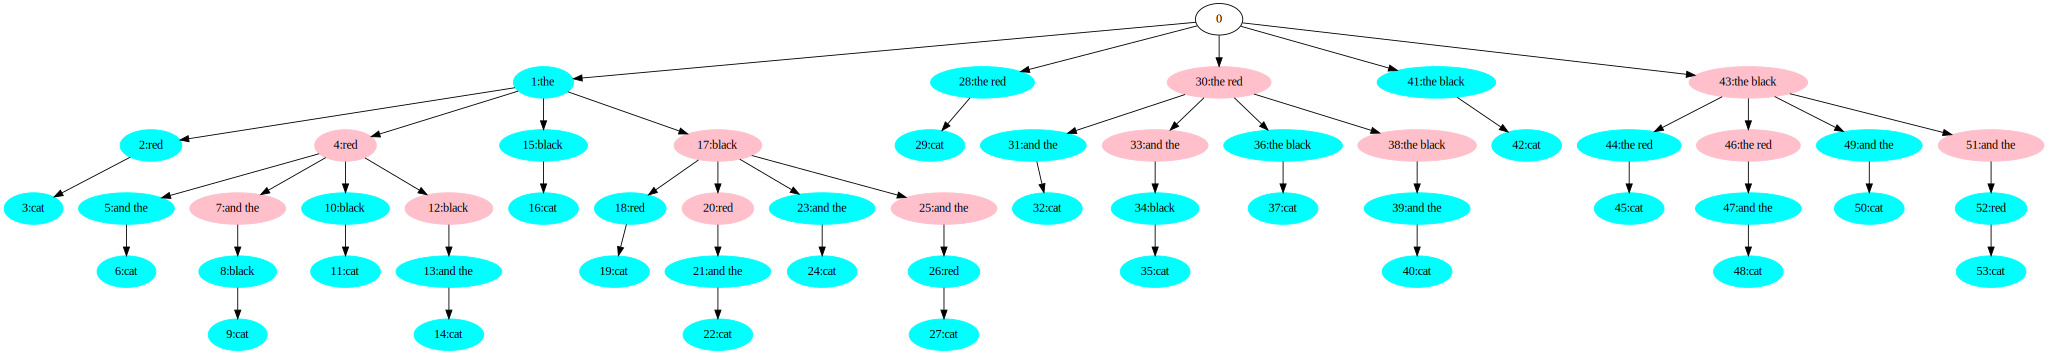

In [84]:
# Source: https://github.com/interedition/collatex/blob/master/collatex-pythonport/collatex/display_module.py
# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
for key,value in decision_tree.items():
    if value['id'] != 0:
        node_id = str(value['id'])
        if value['type'] == 'transpose':
            fill_color = 'pink'
            ngram_text = value['transposed-patterns'][len(value['transposed-patterns']) - 1][2]
        else:
            fill_color = 'cyan'
            ngram_text = value['aligned-patterns'][len(value['aligned-patterns']) - 1][2]
        a.node(node_id, label=node_id + ':' + ngram_text, style='filled', color=fill_color)
        a.edge(str(value['parent']), str(value['id']))
SVG(a.view())

## Output table of paths, sorted from best to worst

Sort by, in order:

1. Aligned token count (high is better)
1. Path length (node count; low is better)
1. Transposition count (pattern count; low is better)

In [85]:
from IPython.display import HTML
evaluation_report = ['<table border><tr style="text-align:center;"><th>Leaf<br/>id</th><th>Aligned<br/>nodes</th><th>Path<br/>length</th><th>Transposed<br/>patterns</th></tr>']
evaluation_data = []
for key, value in decision_tree.items():
    if not(value['children']): # it's a leaf node
        path_length = len(value['aligned-patterns'])
        token_count = 0 # counts tokens, not ngrams (nodes)
        transposition_count = 0 # counts nodes (not tokens)
        for t in value['aligned-patterns']:
            token_count += ngram_length[t[2]]
        for t in value['transposed-patterns']:
            transposition_count += 1
        evaluation_data.append((value['id'], token_count, path_length, transposition_count))
evaluation_data.sort(key = lambda x : (-x[1], x[2], x[3], x[0]))
for leaf in (evaluation_data):
    evaluation_report.append('<tr style="text-align:right;"><td>' + str(leaf[0]) + '</td><td>' + str(leaf[1]) + '</td><td>' + str(leaf[2]) + '</td><td>' + str(leaf[3]) + '</td></tr>')
evaluation_report.append('</table>')
HTML(''.join(evaluation_report))

Leafid,Alignednodes,Pathlength,Transposedpatterns
6,4,3,2
14,4,3,2
22,4,3,2
24,4,3,2
29,3,2,2
32,3,2,2
37,3,2,2
40,3,2,2
42,3,2,2
45,3,2,2
